# **02 - Modelling**

En Xepelin estamos desarrollando un nuevo producto para las pymes de latinoamérica, y tu objetivo como miembro del equipo de Data es analizar los datos transaccionales disponible y generar un modelo que permita predecir cuánto dinero se pagará a través de este producto y cuanto se financiará por Xepelin.

**NOTE: Un modelo que prediga el flujo total a través del producto.**

**Otro modelo que prediga cuanto financiará por Xepelin**

En esta notebook se presenta el modelado.

Primero se crea un benchmark con reg lineal.

Luego se hace un linea de auto ML. Modelos de estadística clásicos

Y por ultimo un Fb prophet


## 00 - Dependencies

In [1]:
#Data Wrangling
import datetime
from math import sqrt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('bmh')
%matplotlib inline
import seaborn as sns
sns.set()

#Stats Time Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

#ML Time Series
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 01 - Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df['paidAt']=pd.to_datetime(df['paidAt'])
#Truncate to days
df['paidAt']=df['paidAt'].dt.floor('d')

## 02 - Data Preprocessing

Como queremos determinar dinero que se pagará a través del producto y por otro lado, el financiado por Xepelin, nos quedaremos con las instancias que se han efectuado.

In [3]:
df = df[df['status'] == 'PAID']
df.set_index('paidAt',inplace=True)

Para el modelo de caudal total resampleo por Mes y Semana

In [4]:
df

,PayerId,ReceiverId,invoiceId,amount,amountfinancedByXepelin,status
paidAt,,,,,,
2021-08-23,53,10,18660729,"1,490.46",0.00,PAID
2021-03-22,93,11,18660730,"6,418.28",624.48,PAID
2021-02-18,122,12,18660731,"27,979.20","10,520.15",PAID
2021-03-15,85,13,18660732,"183,070.77","79,421.63",PAID
2021-07-23,87,14,18660733,"20,532.00","20,532.00",PAID
...,...,...,...,...,...,...
2021-06-03,163,143,18661846,"1,490.26",0.00,PAID
2021-05-24,121,43,18661881,"1,490.26",0.00,PAID
2021-06-25,191,118,18661892,"1,147.86",0.00,PAID


In [5]:
total_month = df['amountfinancedByXepelin'].resample('BMS').sum().to_frame()
total_week =  df['amountfinancedByXepelin'].resample('W', label='left', loffset=pd.DateOffset(days=1)).sum().to_frame()
total_day = df['amountfinancedByXepelin'].resample('d').sum().to_frame()


In [6]:
total_week.rename(columns= {'amountfinancedByXepelin':'amount'},inplace=True)

In [ ]:
total_week

Para el modelo de caudal financiado resampleo por Mes y Semana

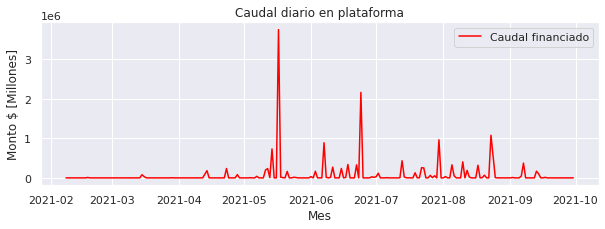

In [7]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_day, color = 'red') 
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal diario en plataforma")


ax.legend([ "Caudal financiado"])

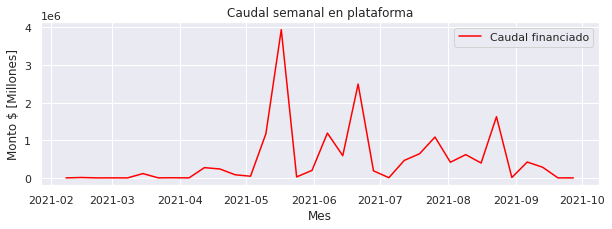

In [8]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_week, color = 'red') 
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal semanal en plataforma")


ax.legend(["Caudal financiado"])

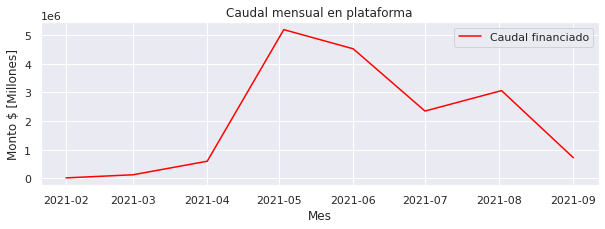

In [9]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(total_month, color = 'red')  
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal mensual en plataforma")
ax.legend([ "Caudal financiado"])

### Data Preprocessing - Suavizando la muestra

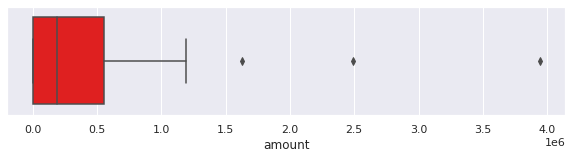

In [15]:
plt.figure(figsize = (10,2))
sns.boxplot(total_week.amount,color = 'red')
plt.show()

In [16]:
# Interpolo valores outliers
Q1 = total_week.amount.quantile(0.25)
Q3 = total_week.amount.quantile(0.75)
IQR = Q3 - Q1

total_week[(total_week.amount < (Q1 - 1.5*IQR)) | (total_week.amount > (Q3 + 1.5*IQR))] = np.nan
total_week = total_week.interpolate()

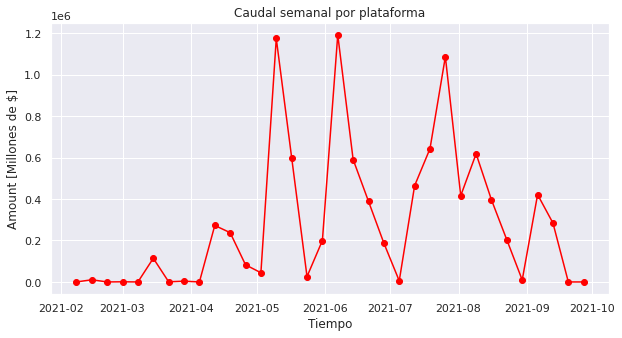

In [17]:
plt.figure(figsize = (10,5))
plt.plot(total_week.index, total_week.amount, 'o-', color = 'red')

plt.title('Caudal semanal por plataforma')
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

## 02 - Benchmark

Empezamos el modelado con algunos benchmark. Van a ser nuestras soluciones mas "naive". Es el baseline que nuestro modelo debería superar para poder analizar si es viable la utilización y futura puesta en producción.

Dentro de los benchmark posibles elijo dos:
1. El valor de t-1 (valor anterior de la serie)
2. Regresión lineal

### A- Regresión lineal

La estrategia para este caso es la de one-step prediction

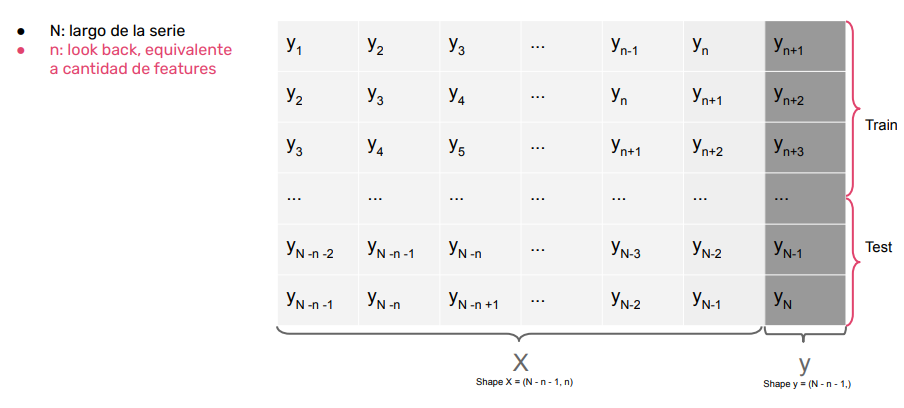

In [25]:
#Duplico para modificar
senial = total_week.amount
senial.shape[0]

34

In [26]:
look_back = 6

In [27]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(27, 6) (27,)


In [28]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [29]:
N_train = 22 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 6#cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(16, 6) (16,)
(6, 6) (6,)


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)

In [31]:
y_pred = reg.predict(X)
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

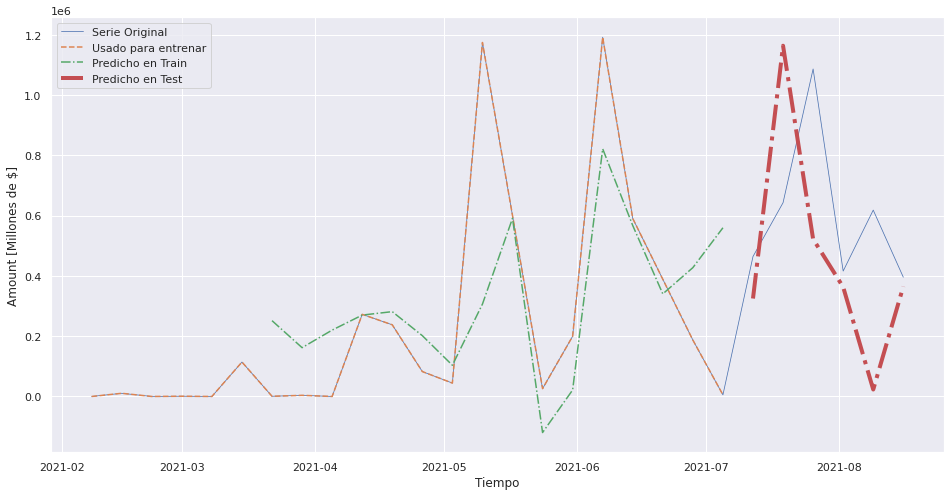

In [32]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [33]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 302844.3334411544
Error en Test: 401485.1749109594


### B - Valor de t-1

In [34]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

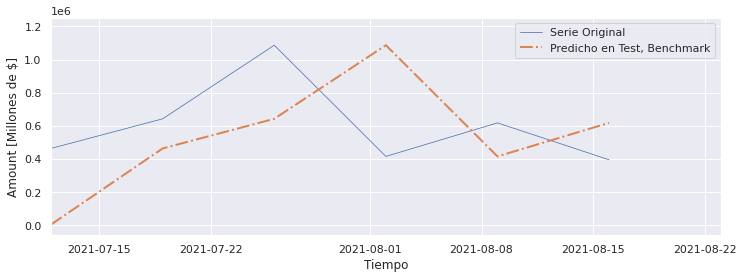

In [35]:

plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.legend()
plt.show()

In [36]:
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print(np.sqrt(MSE))

404007.2742334386


Finalmente obtuvimos los dos RMSE para los benchmark:

1. Regresión Lineal : 401.485

2. Valor t-1 : 404.007

##  **03 - Approach -Técnicas Tradicionales de pronóstico de series de tiempo**

Antes de aplicar cualquier modelo estadístico en Time Series, hay que verificar que la serie que estamos analizando es estacionaria. Esto quiere decir que en diferentes periodos de tiempo:

* Tiene una media constante

* Tiene una varianza o desviación estandard constante

* Auto-covarianza no debe depender del tiempo

La tendencia y la estacionalidad son dos razones por las que una serie temporal no es estacionaria y, por lo tanto, debe corregirse.



**Técnica para verificar si la serie es estacionaria**

Si bien, hay diferentes maneras de verificar esto. En este caso voy a utilizar ADCF Test - Augmented Dickey-Fuller test.

Este test se utiliza para darnos varios valores que pueden ayudar a identificar la estacionariedad. La hipótesis nula dice que un TS no es estacionario. Se compone de estadísticas de prueba y algunos valores críticos para algunos niveles de confianza. Si las estadísticas de prueba son menores que los valores críticos, podemos rechazar la hipótesis nula y decir que la serie es estacionaria. La prueba ADCF también nos da un valor p. Según la hipótesis nula, valores más bajos de p es mejor.

In [37]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='red', label='Original')
    mean = plt.plot(movingAverage, color='blue', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['amount'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

In [18]:
#Copio DS por transformaciones futuras
week = total_week[['amount']]
week.shape[0]

34

In [19]:
#Convierto los ceros a 1. Esto para cuando apliquemos logaritmo no convierta a infinito
week[week['amount'] ==0]=1

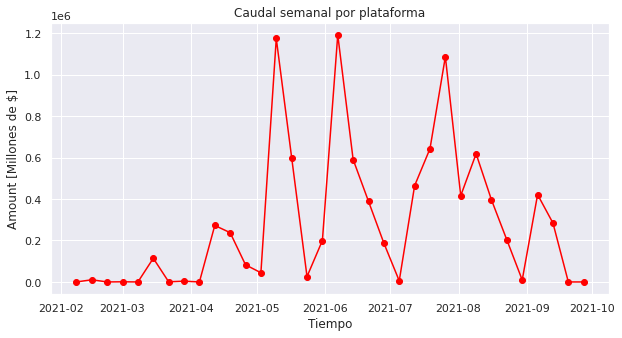

In [40]:
plt.figure(figsize = (10,5))
plt.plot(total_week.index, total_week.amount, 'o-', color = 'red')

plt.title('Caudal semanal por plataforma')
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [41]:
#Determinamos rolling statistics
rolmean = week.rolling(window=6).mean() 
rolstd = week.rolling(window=6).std()

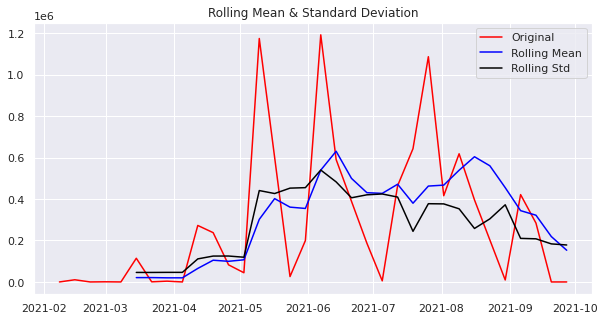

In [42]:
#Plot rolling statistics
plt.figure(figsize = (10,5))
orig = plt.plot(week, color='red', label='Original')
mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [43]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(week['amount'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -3.50
p-value                        0.01
#Lags Used                     1.00
Number of Observations Used   32.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.96
Critical Value (10%)          -2.62
dtype: float64


Para que una serie de tiempo sea estacionaria, su prueba ADCF debe tener:



1.   Valor p bajo (según la hipótesis nula)
2.   Los valores críticos en intervalos de confianza del 1 %, 5 % y 10 % deben estar lo más cerca posible de las estadísticas de prueba.



Del resultado de la prueba ADCF anterior, vemos que el valor p es muy bajo. Además, los valores críticos están cerca de las estadísticas de prueba. Por lo tanto, podemos decir con seguridad que nuestra serie temporal en este momento es estacionaria

### Técnicas de Time Shifting

Teniendo una observación en el tiempo como 
`x0,x1,x2,x3,....xn `

Los shifted values serán : 
`null,x0,x1,x2,....xn`  <---- Básicamente las Xi se desplazan un lugar hacia la derecha.

Así, las series de tiempo con valores desplazados en el tiempo son:
`null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)`

In [44]:
week_shifting = week - week.shift()
week_shifting.dropna(inplace=True)

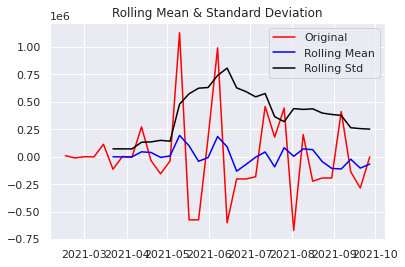

Results of Dickey Fuller Test:
Test Statistic                -6.20
p-value                        0.00
#Lags Used                     2.00
Number of Observations Used   30.00
Critical Value (1%)           -3.67
Critical Value (5%)           -2.96
Critical Value (10%)          -2.62
dtype: float64


In [45]:
test_stationarity(week_shifting)

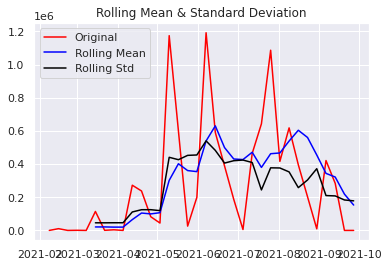

Results of Dickey Fuller Test:
Test Statistic                -3.50
p-value                        0.01
#Lags Used                     1.00
Number of Observations Used   32.00
Critical Value (1%)           -3.65
Critical Value (5%)           -2.96
Critical Value (10%)          -2.62
dtype: float64


In [46]:
test_stationarity(week)

### ACF y PACF

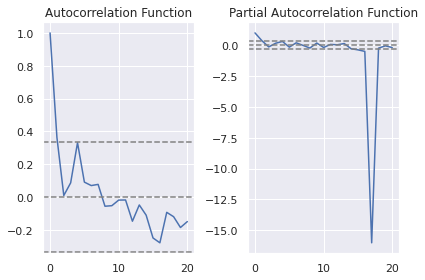

In [47]:
#ACF & PACF plots

lag_acf = acf(week, nlags=20)
lag_pacf = pacf(week, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(week)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()  

### Building Models - AR , MA y ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'AR model')

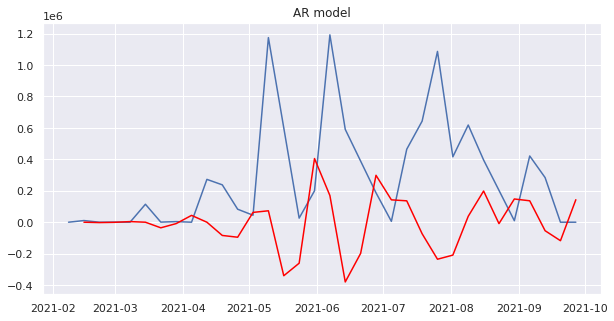

In [48]:
#AR Model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(2,1,0))
results_AR = model.fit(disp=-1)

plt.plot(week)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MA')

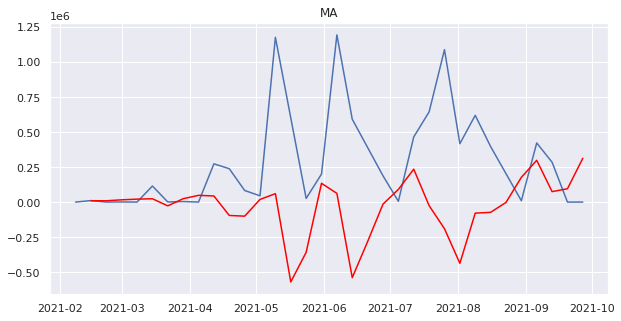

In [49]:
#MA Model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(week)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'ARIMA')

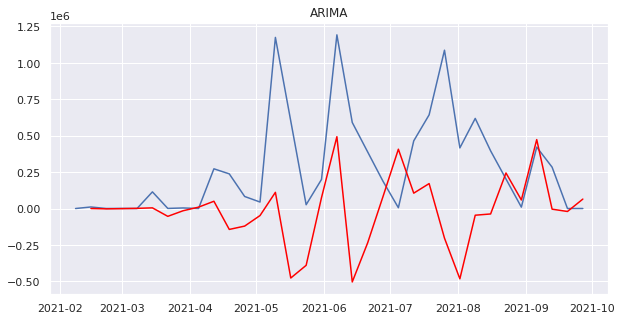

In [50]:
# AR+I+MA = ARIMA model
plt.figure(figsize = (10,5))
model = ARIMA(week, order=(5,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(week)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA')

Estas son celdas para la transformación del output

In [51]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

paidAt
2021-02-15        0.00
2021-02-22   -2,366.77
2021-03-01     -979.24
2021-03-08    1,057.03
2021-03-15    4,451.38
dtype: float64


In [52]:
#Convertimos a suma acumulativa
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

paidAt
2021-02-15            0.00
2021-02-22       -2,366.77
2021-03-01       -3,346.01
2021-03-08       -2,288.97
2021-03-15        2,162.40
2021-03-22      -51,605.51
2021-03-29      -66,798.80
2021-04-05      -57,449.45
2021-04-12       -7,650.78
2021-04-19     -151,211.57
2021-04-26     -271,910.90
2021-05-03     -320,252.64
2021-05-10     -209,268.34
2021-05-17     -686,342.09
2021-05-24   -1,076,363.45
2021-05-31   -1,001,472.11
2021-06-07     -508,561.75
2021-06-14   -1,012,607.24
2021-06-21   -1,248,828.37
2021-06-28   -1,166,959.52
2021-07-05     -759,958.09
2021-07-12     -654,548.12
2021-07-19     -483,541.47
2021-07-26     -686,998.13
2021-08-02   -1,169,567.47
2021-08-09   -1,215,561.31
2021-08-16   -1,252,986.69
2021-08-23   -1,008,999.22
2021-08-30     -950,413.63
2021-09-06     -477,417.72
2021-09-13     -481,954.84
2021-09-20     -502,357.59
2021-09-27     -437,654.34
dtype: float64


In [53]:
predictions_ARIMA_log = pd.Series(week['amount'].iloc[0], index=week.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

paidAt
2021-02-08        1.00
2021-02-15        1.00
2021-02-22   -2,365.77
2021-03-01   -3,345.01
2021-03-08   -2,287.97
dtype: float64

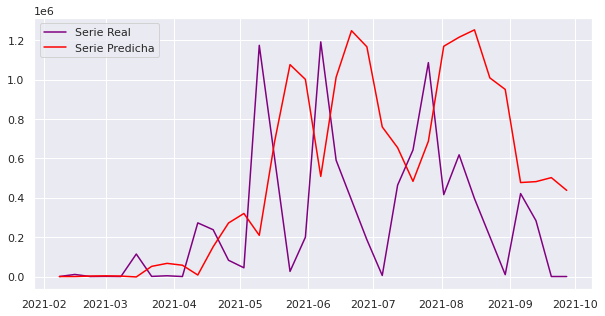

In [54]:
# Inverse of log is exp.
plt.figure(figsize = (10,5))
predictions_ARIMA = -(predictions_ARIMA_log)
plt.plot(week, color = 'purple')
plt.plot(predictions_ARIMA,'red')
plt.legend(['Serie Real', 'Serie Predicha'])
 #plt.ylim((-100,5000000))

### ARIMA Model

Separamos en train y test para poder cuantificar errores

In [55]:
#Split dataset
X = week.amount
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

predicted=385416.794233, expected=464302.940000
predicted=941618.502845, expected=642816.560000
predicted=425381.697575, expected=1086527.730000
predicted=549716.054774, expected=416015.430000
predicted=319459.560040, expected=618258.600000
predicted=622742.808887, expected=395796.820000
predicted=821094.451343, expected=202663.215000
predicted=455155.037905, expected=9529.610000
predicted=597181.819256, expected=421309.370000
predicted=471760.762615, expected=283896.790000
predicted=309154.910092, expected=1.000000
predicted=85056.771878, expected=1.000000
Test RMSE: 346573.073


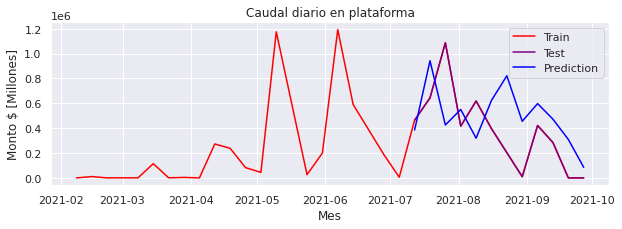

In [56]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(week,color = 'red')
ax.plot(test,color = 'purple')
predictions = pd.Series(predictions,index = test.index)
ax.plot(predictions, color='blue')
ax.set_xlabel("Mes")
ax.set_ylabel("Monto $ [Millones]")
ax.set_title("Caudal diario en plataforma")
ax.legend(["Train", "Test","Prediction"])

**El RMSE total es 346.573**

Mejor que la regresión lineal y que el valor de t-1

## **04 - Approach : Machine Learning para series de tiempo**

En este enfoque de Machine Learning voy a entrenar modelos regresión a través de estrategias de One-Step y Multi-step prediction.

Después resolveremos el mismo problema con la librería de Facebook, Prophet.

Por último, utilizaré una librería de Low-Code Machine learning llamada pycaret para ver si alguno de los modelos que nos ofrece tiene performance superior que las opciones analizadas.

### **A - One-Step Prediction**

In [57]:
senial = total_week.amount
senial.head()

paidAt
2021-02-08        0.00
2021-02-15   10,520.15
2021-02-22        0.00
2021-03-01      737.99
2021-03-08        0.00
Name: amount, dtype: float64

In [58]:
look_back = 6

In [59]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(27, 6) (27,)


In [60]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [61]:
N_train = 22 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 6#cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(16, 6) (16,)
(6, 6) (6,)


In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

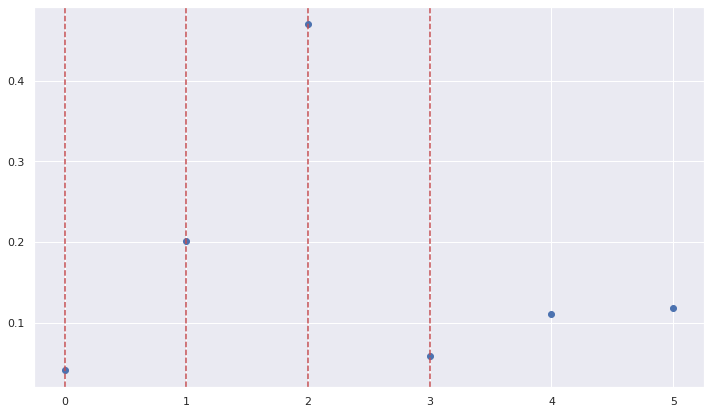

In [63]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
for x in np.arange(4):
     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [64]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

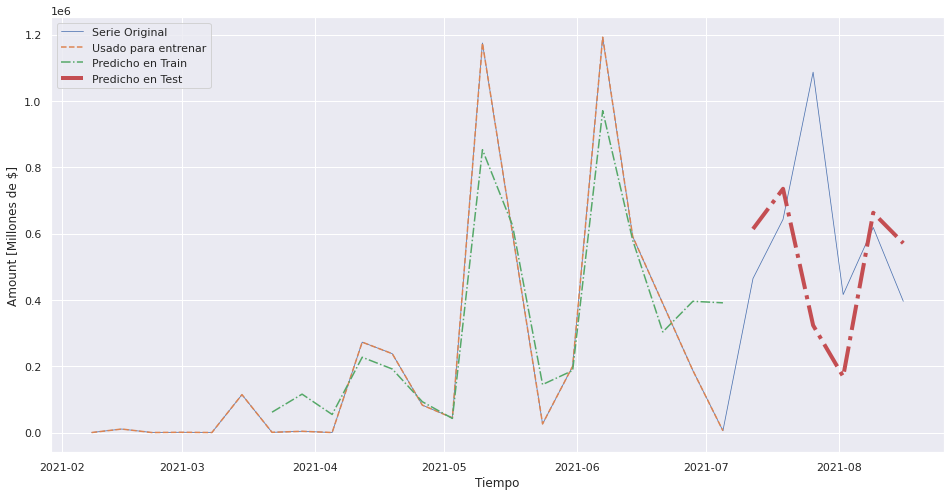

In [65]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [66]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 156267.01921135123
Error en Test: 343269.1316664418


### B - Multi-Step Prediction

In [67]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

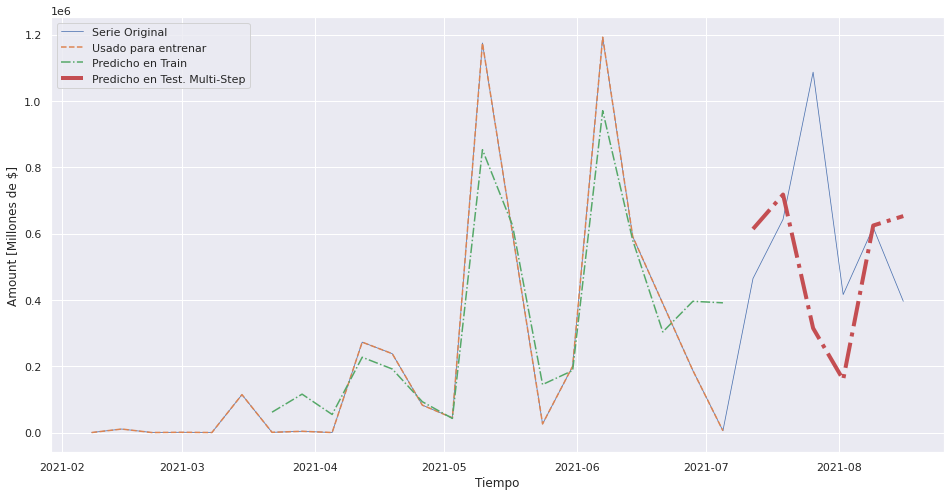

In [68]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amount [Millones de $]')
plt.show()

In [69]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Train:',np.sqrt(MSE))

Error en Train: 354882.1616809832


### **D - PyCaret**

In [ ]:
!pip install pycaret

In [79]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.2

Found existing installation: scikit-learn 0.23.2
Uninstalling scikit-learn-0.23.2:
  Successfully uninstalled scikit-learn-0.23.2
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)


In [20]:
week.reset_index(inplace=True)
week.dropna(inplace=True)

In [21]:
week['month'] = week['paidAt'].dt.month
week['year'] = week['paidAt'].dt.year
week['day_of_week'] = week['paidAt'].dt.day_of_week
week['day_of_year'] = week['paidAt'].dt.day_of_year

In [22]:
train = week[week['month']<8]
test = week[week['month']>=8]

In [23]:
pycaret_test = week[["paidAt", "amount",'month',	'year',	'day_of_week',	'day_of_year']]
pycaret_test.drop(columns = ['paidAt'],inplace = True)
train = pycaret_test[pycaret_test['month']<8]
test = pycaret_test[pycaret_test['month']>=8]

In [24]:
from pycaret.regression import *

s = setup(data = train, test_data = test,
          target = 'amount', 
          fold_strategy = 'timeseries',
          numeric_features = ['month', 'year','day_of_week','day_of_year'],
          fold = 3,
          transform_target = True,
          session_id = 123, silent = True,
          log_experiment = True, experiment_name = 'amount')

,Description,Value
0,session_id,123
1,Target,amount
2,Original Data,"(25, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(25, 4)"


2022/04/19 06:16:06 INFO mlflow.tracking.fluent: Experiment with name 'amount' does not exist. Creating a new experiment.


In [25]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,"297,729.72","168,841,761,875.22","369,932.63",-0.63,2.80,41.76,0.05
dt,Decision Tree Regressor,"336,462.77","231,912,861,978.41","417,592.78",-0.95,3.17,41.43,0.02
et,Extra Trees Regressor,"336,462.77","231,912,861,978.41","417,592.78",-0.95,3.17,41.43,0.20
gbr,Gradient Boosting Regressor,"337,865.00","232,983,679,397.90","419,116.40",-0.96,3.17,41.48,0.05
rf,Random Forest Regressor,"339,751.21","232,779,530,801.81","421,540.10",-0.97,2.96,97.49,0.28
knn,K Neighbors Regressor,"334,082.71","240,624,831,432.79","423,989.86",-1.00,3.65,10.31,0.08
par,Passive Aggressive Regressor,"340,760.36","248,001,252,788.13","428,878.57",-1.04,3.55,70.09,0.02
dummy,Dummy Regressor,"393,537.49","308,068,151,374.81","492,838.21",-1.54,4.79,6.79,0.02
lightgbm,Light Gradient Boosting Machine,"393,537.49","308,068,151,337.53","492,838.21",-1.54,4.79,6.79,0.18
llar,Lasso Least Angle Regression,"393,537.49","308,068,151,396.00","492,838.21",-1.54,4.79,6.79,0.03


El mejor es un DecissionTreeRegressor con un RMSE de 659.996

## 05 - Conclusión

Finalmente tenemos lo siguiente:

**Benchmark**
1. Regresión Lineal : 401.485

2. Valor t-1 : 404.007

**Traditional Time Series**
1. ARIMA : 346.573

**Machine Learning**
1. Random Forest (OSP): 343.269

2. Random Forest (MSP): 354.882

4. PyCaret [ Ada Boost ]: 369,932

Mi elección final es el Random Forest utilizando One-Step Prediction. Además de que el performance superó el performance, es un modelo más simple tanto desde la aplicabilidad como la interpretación del mismo.
